In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import time

np.random.seed(42)


class Activation:
    @staticmethod
    def relu(z):
        return np.maximum(0, z)
    
    @staticmethod
    def relu_derivative(z):
        return np.where(z > 0, 1, 0)

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def sigmoid_derivative(z):
        s = Activation.sigmoid(z)
        return s * (1 - s)

    @staticmethod
    def tanh(z):
        return np.tanh(z)
    
    @staticmethod
    def tanh_derivative(z):
        return 1 - np.tanh(z)**2

    @staticmethod
    def LeakyReLU(z, alpha=0.01):
        return np.maximum(alpha*z, z)
    
    @staticmethod
    def LeakyReLU_derivative(z, alpha=0.01):
        return np.where(z > 0, 1, alpha)

    @staticmethod
    def linear(z):
        return z
    
    @staticmethod
    def linear_derivative(z):
        return np.ones_like(z)
    
    @staticmethod
    def softmax(z):
        # Ficou brabo, not stable 
        # (https://stackoverflow.com/questions/40575841/numpy-calculate-the-derivative-of-the-softmax-function)
        # So we subtract the maximum value from the input to make it stable
        e_x = np.exp(z - np.max(z, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)
    
    @staticmethod
    def softmax_derivative(z):
        # Compute softmax for z
        s = Activation.softmax(z)  # shape (batch_size, num_classes)
        
        # For each sample in the batch, compute the derivative
        # Softmax derivative simplification for backpropagation
        return s * (1 - s)
    
class Loss:
    @staticmethod
    def MSE(y, y_hat):
        return 1 / y.shape[0]*(y - y_hat).T @ (y - y_hat)
    
    def MSE_derivative(y, y_hat):
        return y_hat - y

    @staticmethod
    def BCE(y, y_hat):
        return -1 / y.shape[0] * (y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    
    def BCE_derivative(y, y_hat):
        return (y_hat - y) / (y_hat * (1 - y_hat))
    
    @staticmethod
    def CrossEntropy(y, y_hat):
        y_hat = np.clip(y_hat, 1e-15, 1-1e-15)
        return -1 / y.shape[0] * np.sum(y * np.log(y_hat))
    
    def CrossEntropy_derivative(y, y_hat):
        return y_hat - y
    
class Initialization:
    @staticmethod
    def xavier(size):
        (fan_in, fan_out) = size[0], size[1]
        stddev = np.sqrt(2 / (fan_in + fan_out))
        return np.random.normal(0, stddev, size=size)
    
    @staticmethod
    def he(size):
        fan_in = size[0]
        stddev = np.sqrt(2 / fan_in)
        return np.random.normal(0, stddev, size=size)
    
    @staticmethod
    def normal(size):
        return np.random.randn(*size)
    
    @staticmethod
    def uniform(size):
        return np.random.uniform(size=size)
    
    @staticmethod
    def zeros(size):
        return np.zeros(size)

class Optimizer:
    def __init__(self, learning_rate, network):
        self.learning_rate = learning_rate
        self.grads = network.grads
        self.weights = network.weights
        self.biases = network.biases
    
    def zero_grad(self):
        return {key: np.zeros_like(value) for key, value in self.grads.items()}

class SGD(Optimizer):
    def __init__(self, learning_rate, network):
        super().__init__(learning_rate, network)
        
    def step(self):
        for i in range(len(self.weights)):
            
            self.weights[i] = self.weights[i] - self.learning_rate * self.grads[f'dw{i+1}']
            self.biases[i] = self.biases[i] - self.learning_rate * self.grads[f'db{i+1}']
            
        return self.weights, self.biases

class Adam(Optimizer):
    def __init__(self, learning_rate, network, beta1=0.9, gamma=0.999, epsilon=1e-8):
        super().__init__(learning_rate, network)
        self.beta1 = beta1
        self.gamma = gamma
        self.epsilon = epsilon
        # Initializing as zeros so that we can have momentum and RMSprop for each parameter
        self.m_w = [np.zeros_like(w) for w in self.weights]
        self.v_w = [np.zeros_like(w) for w in self.weights]
        self.m_b = [np.zeros_like(b) for b in self.biases]
        self.v_b = [np.zeros_like(b) for b in self.biases]
        self.t = 0
        
    def step(self):
        self.t += 1
        for i in range(len(self.weights)):
            # Update for weights
            self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * self.grads[f'dw{i+1}']
            self.v_w[i] = self.gamma * self.v_w[i] + (1 - self.gamma) * np.square(self.grads[f'dw{i+1}'])
            m_w_hat = self.m_w[i] / (1 - self.beta1**self.t)
            v_w_hat = self.v_w[i] / (1 - self.gamma**self.t)
            self.weights[i] = self.weights[i] - self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            
            # Update for biases
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * self.grads[f'db{i+1}']
            self.v_b[i] = self.gamma * self.v_b[i] + (1 - self.gamma) * np.square(self.grads[f'db{i+1}'])
            m_b_hat = self.m_b[i] / (1 - self.beta1**self.t)
            v_b_hat = self.v_b[i] / (1 - self.gamma**self.t)
            self.biases[i] = self.biases[i] - self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)
        
        return self.weights, self.biases
    
    
class MLP:
    def __init__(self, neurons, activations, weight_initialization) -> None:
        self.MLP_DEPTH = len(neurons) - 1
        self.neurons = neurons
        if len(activations) == 1:
            self.activations = [activations[0] for _ in range(self.MLP_DEPTH)]
        elif len(activations) == 2 and self.MLP_DEPTH > 2:
            self.activations = [activations[0] for _ in range(self.MLP_DEPTH)]
            self.activations[-1] = activations[1]
        else:
            self.activations = activations
            
        self.activation_derivatives = [getattr(Activation, f"{activation.__name__}_derivative") for activation in self.activations]
        
        
        if isinstance(weight_initialization, list):
            # Direct weight assignment
            self.weights = weight_initialization
        else:
            # Use initialization method
            self.weights = [np.squeeze(weight_initialization((neurons[i+1], neurons[i]))) for i in range(self.MLP_DEPTH)]
            
        self.biases = [np.zeros((neurons[i + 1])) for i in range(self.MLP_DEPTH)]
        
        self.cache = {}
        self.grads = {}
    
    def forward(self, input):

        self.cache['a0'] = a = input
        
        for i in range(self.MLP_DEPTH):
            z = a @ self.weights[i].T + self.biases[i]
            a = self.activations[i](z)

            self.cache[f'w{i+1}'] = self.weights[i]
            self.cache[f'z{i+1}'] = z
            self.cache[f'a{i+1}'] = a
            
        return a

    def backward(self, y, loss):
        BATCH_SIZE = y.shape[0]
        
        self.loss_derivative = getattr(Loss, f"{loss.__name__}_derivative")
        
        # Output layer
        dz = self.loss_derivative(y, self.cache[f'a{self.MLP_DEPTH}'])
        da = self.activation_derivatives[self.MLP_DEPTH-1](self.cache[f'z{self.MLP_DEPTH}'])
        dl = dz * da
        
        self.grads[f'dw{self.MLP_DEPTH}'] = (1/BATCH_SIZE) * dl.T @ self.cache[f'a{self.MLP_DEPTH-1}']
        self.grads[f'db{self.MLP_DEPTH}'] = (1/BATCH_SIZE) * np.sum(dz, axis=0, keepdims=True)

        for i in range(self.MLP_DEPTH, 1, -1):
            if len(dl.shape) == 1:
                dl = dl.reshape(-1, 1)
            if len(self.cache[f'w{i}'].shape) == 1:
                self.cache[f'w{i}'] = self.cache[f'w{i}'].reshape(1, -1)

            dz = dl @ self.cache[f'w{i}']

            dz *= self.activation_derivatives[i-1](self.cache[f'a{i-1}'])
            
            self.grads[f'dw{i-1}'] = (1/BATCH_SIZE) * dz.T @ self.cache[f'a{i-2}']
            self.grads[f'db{i-1}'] = (1/BATCH_SIZE) * np.sum(dz, axis=0, keepdims=True)
            dl = dz
            
            
    def save(self, filepath):
        """Save the model weights and biases to a file."""
        model_data = {
            'weights': self.weights,
            'biases': self.biases,
            'neurons': self.neurons,
            'activations': [act.__name__ for act in self.activations]
        }
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filepath}")

    @classmethod
    def load(cls, filepath, weight_initialization):
        """Load a model from a file."""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        # Recreate activation functions from their names
        activations = [getattr(Activation, act_name) for act_name in model_data['activations']]
        
        # Create a new instance of the model
        model = cls(model_data['neurons'], activations, weight_initialization)
        
        # Load the weights and biases
        model.weights = model_data['weights']
        model.biases = model_data['biases']
        
        print(f"Model loaded from {filepath}")
        return model


In [2]:
class Dataset:
    def __init__(self, train_set, train_labels, test_set, test_labels, val_split=0.15, num_classes=10):
        self.train_set = train_set
        self.test_set = test_set
        self.num_classes = num_classes
        
        # One-hot encode the labels
        self.train_labels = self.one_hot_encode(train_labels)
        self.test_labels = self.one_hot_encode(test_labels)
        
        # Create validation set
        val_size = int(len(train_set) * val_split)
        self.val_set = train_set[-val_size:]
        self.val_labels = self.train_labels[-val_size:]
        self.train_set = train_set[:-val_size]
        self.train_labels = self.train_labels[:-val_size]
    
    def one_hot_encode(self, labels):
        # Ensure labels is a 1D array
        labels = np.array(labels).ravel()
        # Check if labels are in the correct range
        if np.min(labels) < 0 or np.max(labels) >= self.num_classes:
            raise ValueError(f"Labels must be in the range 0 to {self.num_classes-1}")
        # Create one-hot encoded array
        one_hot = np.zeros((labels.size, self.num_classes))
        one_hot[np.arange(labels.size), labels] = 1
        return one_hot
    
    def create_batches(self, batch_size, dataset='train'):
        if dataset == 'train':
            data, labels = self.train_set, self.train_labels
        elif dataset == 'val':
            data, labels = self.val_set, self.val_labels
        elif dataset == 'test':
            data, labels = self.test_set, self.test_labels
        else:
            raise ValueError("dataset must be 'train', 'val', or 'test'")
        
        indices = np.arange(len(data))
        np.random.shuffle(indices)
        for start_idx in range(0, len(data), batch_size):
            batch_indices = indices[start_idx:start_idx+batch_size]
            yield data[batch_indices], labels[batch_indices]
    
    def get_test_data(self):
        return self.test_set, self.test_labels
    
    def get_val_data(self):
        return self.val_set, self.val_labels

In [3]:
def test_whole_set(model, test_data, test_labels, loss_fn):
    y_hat = model.forward(test_data)
    total_loss = loss_fn(test_labels, y_hat)
    
    predictions = np.argmax(y_hat, axis=1)
    true_labels = np.argmax(test_labels, axis=1)
    accuracy = np.mean(predictions == true_labels)
    
    return accuracy, total_loss


def train(model, dataset, epochs, optimizer, loss_fn, batch_size=32, save_path="./models/best_model.pkl"):
    metrics = {}
    metrics["train_loss"] = []
    metrics["val_loss"] = []
    metrics["val_acc"] = []
    metrics["network_grads"] = []
    metrics["network_activations"] = []
    metrics["train_time"] = []
    best_val_acc = 0
    
    for epoch in tqdm(range(epochs)):
        batch_loss = 0
        
        for X_batch, y_batch in dataset.create_batches(batch_size, 'train'):
            
            start = time.time()
            pred = model.forward(X_batch)
            batch_loss += loss_fn(y_batch, pred)
            model.backward(y_batch, loss_fn)
            model.weights, model.biases = optimizer.step()
            metrics["network_grads"].append(model.grads)
            metrics["network_activations"].append([v for k,v in model.cache.items() if 'a' in k and '0' not in k])
            
        metrics["train_time"].append(time.time() - start)
        
        # Validate on validation set
        val_acc, val_loss = test_whole_set(model, *dataset.get_val_data(), loss_fn)
        metrics["val_loss"].append(val_loss)
        metrics["val_acc"].append(val_acc)
        metrics["train_loss"].append(batch_loss / (len(dataset.train_set) // batch_size))
        print(f"Epoch {epoch} Train Loss: {metrics['train_loss'][-1]:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}")
        
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model.save(save_path)
            print(f"New best model saved with validation accuracy: {best_val_acc:.4f}")
            
    return metrics


In [4]:
train_set = np.load('data/mnist_train_data.npy')
train_labels = np.load('data/mnist_train_labels.npy')
test_set = np.load('data/mnist_test_data.npy')
test_labels = np.load('data/mnist_test_labels.npy')

dataset = Dataset(train_set, train_labels, test_set, test_labels)

In [5]:
EPOCHS = 50
BATCH_SIZE = 64
loss_fn = Loss.CrossEntropy
MODEL = MLP([784, 512, 10], [Activation.relu, Activation.softmax], Initialization.he)
optim = Adam(1e-4, MODEL)
training_metrics  = train(MODEL, dataset, EPOCHS, optim, loss_fn, BATCH_SIZE)

  2%|▏         | 1/50 [00:07<05:56,  7.28s/it]

Epoch 0 Train Loss: 3.3155, Val Acc: 0.8606, Val Loss: 1.2859
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.8606


  4%|▍         | 2/50 [00:13<05:19,  6.66s/it]

Epoch 1 Train Loss: 1.2316, Val Acc: 0.8948, Val Loss: 0.9493
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.8948


  6%|▌         | 3/50 [00:18<04:29,  5.73s/it]

Epoch 2 Train Loss: 1.0114, Val Acc: 0.9052, Val Loss: 0.8386
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9052


  8%|▊         | 4/50 [00:23<04:19,  5.63s/it]

Epoch 3 Train Loss: 0.9000, Val Acc: 0.9112, Val Loss: 0.7605
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9112


 10%|█         | 5/50 [00:28<03:55,  5.23s/it]

Epoch 4 Train Loss: 0.8386, Val Acc: 0.9148, Val Loss: 0.7293
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9148


 12%|█▏        | 6/50 [00:32<03:35,  4.89s/it]

Epoch 5 Train Loss: 0.8066, Val Acc: 0.9189, Val Loss: 0.7038
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9189


 14%|█▍        | 7/50 [00:35<03:12,  4.47s/it]

Epoch 6 Train Loss: 0.7839, Val Acc: 0.9198, Val Loss: 0.6908
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9198


 16%|█▌        | 8/50 [00:40<03:10,  4.54s/it]

Epoch 7 Train Loss: 0.7656, Val Acc: 0.9212, Val Loss: 0.6838
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9212


 18%|█▊        | 9/50 [00:44<02:54,  4.25s/it]

Epoch 8 Train Loss: 0.7487, Val Acc: 0.9226, Val Loss: 0.6684
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9226


 20%|██        | 10/50 [00:48<02:44,  4.11s/it]

Epoch 9 Train Loss: 0.7341, Val Acc: 0.9248, Val Loss: 0.6629
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9248


 22%|██▏       | 11/50 [00:51<02:34,  3.96s/it]

Epoch 10 Train Loss: 0.7281, Val Acc: 0.9247, Val Loss: 0.6652


 24%|██▍       | 12/50 [00:55<02:23,  3.79s/it]

Epoch 11 Train Loss: 0.7287, Val Acc: 0.9246, Val Loss: 0.6681


 26%|██▌       | 13/50 [00:58<02:16,  3.70s/it]

Epoch 12 Train Loss: 0.7260, Val Acc: 0.9248, Val Loss: 0.6606


 28%|██▊       | 14/50 [01:02<02:11,  3.64s/it]

Epoch 13 Train Loss: 0.7214, Val Acc: 0.9262, Val Loss: 0.6544
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9262


 30%|███       | 15/50 [01:05<02:07,  3.65s/it]

Epoch 14 Train Loss: 0.7187, Val Acc: 0.9254, Val Loss: 0.6629


 32%|███▏      | 16/50 [01:09<02:01,  3.58s/it]

Epoch 15 Train Loss: 0.7224, Val Acc: 0.9271, Val Loss: 0.6629
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9271


 34%|███▍      | 17/50 [01:12<01:57,  3.58s/it]

Epoch 16 Train Loss: 0.7236, Val Acc: 0.9276, Val Loss: 0.6724
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9276


 36%|███▌      | 18/50 [01:17<02:04,  3.88s/it]

Epoch 17 Train Loss: 0.7236, Val Acc: 0.9280, Val Loss: 0.6709
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9280


 38%|███▊      | 19/50 [01:22<02:13,  4.31s/it]

Epoch 18 Train Loss: 0.7256, Val Acc: 0.9283, Val Loss: 0.6759
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9283


 40%|████      | 20/50 [01:27<02:11,  4.37s/it]

Epoch 19 Train Loss: 0.7268, Val Acc: 0.9292, Val Loss: 0.6727
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9292


 42%|████▏     | 21/50 [01:32<02:11,  4.54s/it]

Epoch 20 Train Loss: 0.7344, Val Acc: 0.9270, Val Loss: 0.7033


 44%|████▍     | 22/50 [01:36<02:05,  4.48s/it]

Epoch 21 Train Loss: 0.7384, Val Acc: 0.9278, Val Loss: 0.6935


 46%|████▌     | 23/50 [01:40<02:01,  4.49s/it]

Epoch 22 Train Loss: 0.7418, Val Acc: 0.9291, Val Loss: 0.6879


 48%|████▊     | 24/50 [01:44<01:52,  4.31s/it]

Epoch 23 Train Loss: 0.7413, Val Acc: 0.9281, Val Loss: 0.6915


 50%|█████     | 25/50 [01:49<01:46,  4.27s/it]

Epoch 24 Train Loss: 0.7417, Val Acc: 0.9287, Val Loss: 0.6915


 52%|█████▏    | 26/50 [01:53<01:41,  4.24s/it]

Epoch 25 Train Loss: 0.7421, Val Acc: 0.9289, Val Loss: 0.7005


 54%|█████▍    | 27/50 [01:57<01:35,  4.16s/it]

Epoch 26 Train Loss: 0.7431, Val Acc: 0.9298, Val Loss: 0.7034
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9298


 56%|█████▌    | 28/50 [02:02<01:39,  4.55s/it]

Epoch 27 Train Loss: 0.7432, Val Acc: 0.9299, Val Loss: 0.6997
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9299


 58%|█████▊    | 29/50 [02:07<01:36,  4.61s/it]

Epoch 28 Train Loss: 0.7453, Val Acc: 0.9300, Val Loss: 0.7076
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9300


 60%|██████    | 30/50 [02:11<01:30,  4.53s/it]

Epoch 29 Train Loss: 0.7493, Val Acc: 0.9301, Val Loss: 0.7052
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9301


 62%|██████▏   | 31/50 [02:15<01:22,  4.36s/it]

Epoch 30 Train Loss: 0.7505, Val Acc: 0.9301, Val Loss: 0.7059


 64%|██████▍   | 32/50 [02:19<01:17,  4.32s/it]

Epoch 31 Train Loss: 0.7519, Val Acc: 0.9316, Val Loss: 0.7081
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9316


 66%|██████▌   | 33/50 [02:24<01:14,  4.40s/it]

Epoch 32 Train Loss: 0.7535, Val Acc: 0.9309, Val Loss: 0.7140


 68%|██████▊   | 34/50 [02:28<01:09,  4.36s/it]

Epoch 33 Train Loss: 0.7537, Val Acc: 0.9324, Val Loss: 0.7184
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9324


 70%|███████   | 35/50 [02:33<01:05,  4.36s/it]

Epoch 34 Train Loss: 0.7565, Val Acc: 0.9331, Val Loss: 0.7177
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9331


 72%|███████▏  | 36/50 [02:37<01:00,  4.31s/it]

Epoch 35 Train Loss: 0.7574, Val Acc: 0.9339, Val Loss: 0.7192
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9339


 74%|███████▍  | 37/50 [02:41<00:56,  4.32s/it]

Epoch 36 Train Loss: 0.7595, Val Acc: 0.9327, Val Loss: 0.7235


 76%|███████▌  | 38/50 [02:46<00:52,  4.41s/it]

Epoch 37 Train Loss: 0.7643, Val Acc: 0.9342, Val Loss: 0.7261
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9342


 78%|███████▊  | 39/50 [02:51<00:50,  4.56s/it]

Epoch 38 Train Loss: 0.7676, Val Acc: 0.9328, Val Loss: 0.7277


 80%|████████  | 40/50 [02:55<00:45,  4.59s/it]

Epoch 39 Train Loss: 0.7700, Val Acc: 0.9339, Val Loss: 0.7366


 82%|████████▏ | 41/50 [03:01<00:43,  4.88s/it]

Epoch 40 Train Loss: 0.7723, Val Acc: 0.9336, Val Loss: 0.7395


 84%|████████▍ | 42/50 [03:06<00:40,  5.06s/it]

Epoch 41 Train Loss: 0.7762, Val Acc: 0.9339, Val Loss: 0.7388


 86%|████████▌ | 43/50 [03:11<00:35,  5.05s/it]

Epoch 42 Train Loss: 0.7783, Val Acc: 0.9333, Val Loss: 0.7464


 88%|████████▊ | 44/50 [03:16<00:30,  5.02s/it]

Epoch 43 Train Loss: 0.7826, Val Acc: 0.9337, Val Loss: 0.7438


 90%|█████████ | 45/50 [03:21<00:24,  4.87s/it]

Epoch 44 Train Loss: 0.7839, Val Acc: 0.9343, Val Loss: 0.7464
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9343


 92%|█████████▏| 46/50 [03:26<00:19,  4.91s/it]

Epoch 45 Train Loss: 0.7868, Val Acc: 0.9346, Val Loss: 0.7513
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9346


 94%|█████████▍| 47/50 [03:31<00:14,  4.94s/it]

Epoch 46 Train Loss: 0.7885, Val Acc: 0.9350, Val Loss: 0.7526
Model saved to ./models/best_model.pkl
New best model saved with validation accuracy: 0.9350


 96%|█████████▌| 48/50 [03:35<00:09,  4.76s/it]

Epoch 47 Train Loss: 0.7911, Val Acc: 0.9337, Val Loss: 0.7551


 98%|█████████▊| 49/50 [03:40<00:04,  4.70s/it]

Epoch 48 Train Loss: 0.7921, Val Acc: 0.9332, Val Loss: 0.7620


100%|██████████| 50/50 [03:49<00:00,  4.58s/it]

Epoch 49 Train Loss: 0.7949, Val Acc: 0.9350, Val Loss: 0.7594


In [6]:
# Later, you can load the best model
loaded_model = MLP.load('models/best_model.pkl', Initialization.he)

# Test the loaded model
test_acc, test_loss = test_whole_set(loaded_model, *dataset.get_test_data(), loss_fn)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Model loaded from models/best_model.pkl
Test Accuracy: 0.9238, Test Loss: 0.8973


7 7


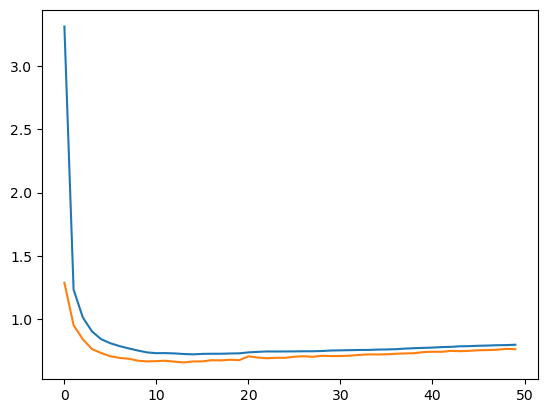

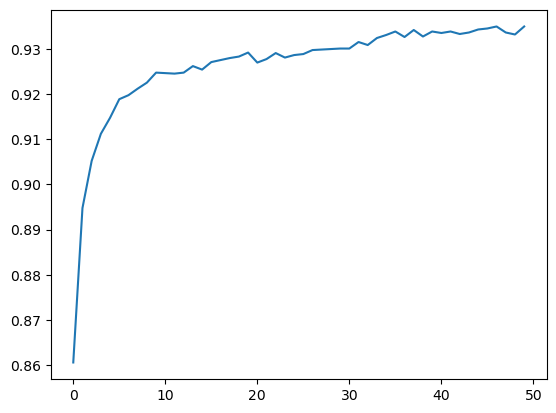

In [9]:
print(np.argmax(MODEL.forward(test_set[0])), test_labels[0])
plt.plot(training_metrics["train_loss"])
plt.plot(training_metrics["val_loss"])
plt.show()
plt.plot(training_metrics["val_acc"])
plt.show()

In [10]:
X = np.array([[0.5, .1], [.2, .6]])
y = np.array([.7, .8])
w0 = np.array([[.5, .2], [.6, -.1], [-.4, -.3]])
w1 = np.array([.7, -.1, .2])

network = MLP([2, 3, 1], [Activation.sigmoid], [w0,w1])

output = network.forward(X)
loss = Loss.MSE(y, output)
print(output)
print(loss)

network.backward(y, Loss.MSE)
optim = SGD(0.1, network)
network.weights, network.biases = optim.step()

[0.60547144 0.60442057]
0.023593481600522267


In [14]:
# TODO: Solve MNIST 1D
# TODO: Plotting Activ and grads in mini-batches
# TODO: Plot val/train loss --
# TODO: Plotting acc / epoch --